In [1]:
import os
# try to control the number of threads used on the eagle dav nodes
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["BLIS_NUM_THREADS"] = "4"

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np
import gzip
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch

In [4]:
nad_prots = pd.read_csv('/projects/bpms/jlaw/inputs/nad_nadp/kegg_nad_uniprot.txt', header=None).squeeze()
print(nad_prots.head())

0    A0A6J0JUL3
1    A0A5Q0QDC4
2        B5XZX7
3    A0A6G7YB72
4        D0A1U1
Name: 0, dtype: object


In [5]:
nadp_prots = pd.read_csv('/projects/bpms/jlaw/inputs/nad_nadp/kegg_nadp_uniprot.txt', header=None).squeeze()
print(nadp_prots.head())

0    A0A1D8P7Q7
1    A0A7L5Y0F6
2    A0A6J0JUL3
3        E0RUK3
4        C5D5T3
Name: 0, dtype: object


In [6]:
prot_set = set(nad_prots) | set(nadp_prots)

In [7]:
print(len(prot_set))

566753


In [8]:
# copied from here: https://stackoverflow.com/a/29805905/7483950
def read_fasta(fp, gzipped=False):
        name, seq = None, []
        for line in fp:
            if gzipped:
                line = line.decode()
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line[1:], []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

In [8]:
fasta_file = "/projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_swissprot_trembl_shortid.fasta.gz"
print(f"reading {fasta_file}")
sequences = {}
# prot_set = set(prots)
with gzip.open(fasta_file, 'r') as f:
    for name, seq in tqdm(read_fasta(f, gzipped=True), total=214406399):
        # just read in the proteins that have GO annotations
        if name not in prot_set:
            continue
        # make sure there aren't these strange AAs
        seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
#         print(name, seq)
        sequences[name] = seq

print(f"\t{len(sequences)} read")

reading /projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_swissprot_trembl_shortid.fasta.gz


  0%|          | 0/214406399 [00:00<?, ?it/s]

	566571 read


In [11]:
# write these sequences to a separate file
with open("/projects/bpms/jlaw/inputs/nad_nadp/kegg_uniprot_seqs.csv", 'w') as out:
    out.write(''.join([f"{s_id},{seq}\n" for s_id, seq in sequences.items()]))

In [9]:
# model_name = "esm1_t6_43M_UR50S"
model_name = "esm1b_t33_650M_UR50S"
torch.hub.set_dir('/scratch/jlaw/torch')
# torch.hub.set_dir('/gpfs/alpine/scratch/jlaw/bie108/torch/hub')
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.eval()
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
# get the representations from the last layer 
repr_layer = model.num_layers

Using cache found in /scratch/jlaw/torch/facebookresearch_esm_main


In [10]:
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

In [11]:
print(f"{len(nad_prots)} NAD seqs, {len(nadp_prots)} NADP seqs, {len(prot_set)} combined")

398091 NAD seqs, 309535 NADP seqs, 566753 combined


In [12]:
# generate the embeddings for these sequences
def get_seq_embeddings(model, seqs, repr_layer=33, batch_size=16):
    """
    Generate an embedding for every sequence using the specified model
    """
    scaler = GradScaler()
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(np.arange(len(seqs)), seqs)))

    batch_dataloader = torch.utils.data.DataLoader(batch_tokens, 
                                                   batch_size=batch_size, 
                                                   pin_memory=True,
                                                   num_workers=8
                                                  )

    representations = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(batch_dataloader), total=len(batch_dataloader)):
            out = model(batch.to(device), repr_layers=[repr_layer])  # because this is the 33-layer transformer
            out = out['representations'][repr_layer].detach().to('cpu').numpy()

            for i in range(len(batch)):
                representations += [out[i, 1:len(batch[i]) + 1].mean(0).astype(np.float16)]
    representations = np.vstack(representations)
    return representations

In [40]:
seq_labels = sorted(prot_set)
seqs = [sequences[l] for l in seq_labels]
seqs = [seq[:1022] if len(seq) > 1022 else seq for seq in seqs]
with autocast():
    representations = get_seq_embeddings(model, seqs, repr_layer=repr_layer, batch_size=64)

  0%|          | 0/267 [00:00<?, ?it/s]

In [13]:
representations = np.load("/projects/bpms/jlaw/inputs/nad_nadp/kegg_uniprot_seq_embeddings.npz")
representations = representations['arr_0']
representations.shape

(566571, 1280)

In [14]:
df = pd.read_csv("/projects/bpms/jlaw/inputs/nad_nadp/kegg_uniprot_seqs.csv.gz", 
                 header=None,
                 names=['seq_id', 'seq']
                )
df.head(2)

,seq_id,seq
0,Q5FTU6,MSSKPDILTIDPLVPVMKERLEKSFTLHPYTSLENLKNIAPAIRGI...
1,C8WMP0,MGIYVITGATSGIGAKTAEILRERGHEVVNIDLNGGDINANLATKE...


In [15]:
nad_prots = set(nad_prots)
nadp_prots = set(nadp_prots)

In [16]:
X = representations
y = [1 if s in nad_prots else 0 for s in df['seq_id']]

In [16]:
sum(y)

397950

In [17]:
len(y) - sum(y)

168621

/home/jlaw/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/jlaw/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


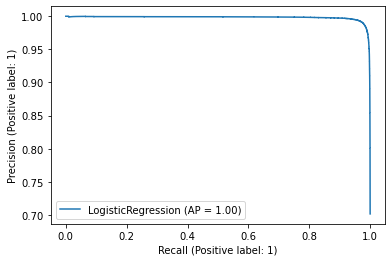

In [32]:
# Reserve 20% of the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(log_reg, X_test, y_test)

In [17]:
# also load the GapN mutant data and compare the NAD+/NADP+ activity
data_dir = "/projects/bpms/jlaw/gapn-engineering/data/"
new_gapn_data_file = f"{data_dir}/20211018-GapN-data-up-to-SM160.csv"
gapn_data = pd.read_csv(new_gapn_data_file, index_col=0)
# drop the barcode of the sequences: MGSSHHHHHHSSGLVPRGSH
gapn_data['Sequence'] = gapn_data['Sequence'].apply(lambda x: x.replace('MGSSHHHHHHSSGLVPRGSH', '').strip('*'))

gapn_reps = get_seq_embeddings(model, gapn_data['Sequence'], repr_layer=repr_layer)

  0%|          | 0/6 [00:00<?, ?it/s]

/home/jlaw/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<AxesSubplot:xlabel='NAD+_initial_rate', ylabel='NADP+_initial_rate'>

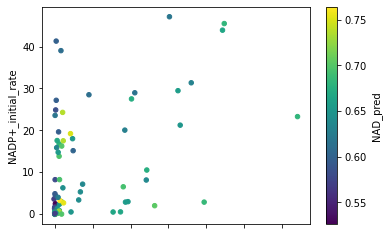

In [18]:
# now train on all training data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)

nad_prob = log_reg.predict_proba(gapn_reps)[:,1].ravel()
gapn_data['NAD_pred'] = nad_prob
gapn_data.plot.scatter(x="NAD+_initial_rate", y="NADP+_initial_rate", c="NAD_pred", cmap="viridis")

<AxesSubplot:xlabel='NAD+_initial_rate', ylabel='NAD_pred'>

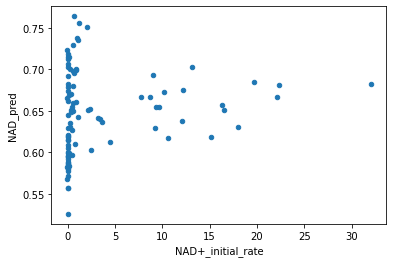

In [19]:
gapn_data.plot.scatter(x="NAD+_initial_rate", y="NAD_pred")

<AxesSubplot:xlabel='NAD+_initial_rate', ylabel='NADP+_initial_rate'>

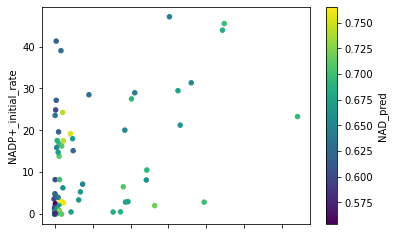

In [40]:
# now train on all training data
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=2):
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X, y)

nad_prob = log_reg.predict_proba(gapn_reps)[:,1].ravel()
gapn_data['NAD_pred'] = nad_prob
gapn_data.plot.scatter(x="NAD+_initial_rate", y="NADP+_initial_rate", c="NAD_pred", cmap="viridis")

In [42]:
nad_file = "/projects/bpms/jlaw/inputs/nad_nadp/kegg_nad_uniprot_match_enz.txt"
nadp_file = "/projects/bpms/jlaw/inputs/nad_nadp/kegg_nadp_uniprot_match_enz.txt"
nad_uniprot_match = set(pd.read_csv(nad_file, header=None).squeeze().values)
nadp_uniprot_match = set(pd.read_csv(nadp_file, header=None).squeeze().values)

In [46]:
nad_idx = []
nad_ids = []
nadp_idx = []
nadp_ids = []
for idx, p in enumerate(df['seq_id'].values):
    if p in nad_uniprot_match:
        nad_idx.append(idx)
        nad_ids.append(p)
    elif p in nadp_uniprot_match:
        nadp_idx.append(idx)
        nadp_ids.append(p)
print(len(nad_idx), len(nadp_idx))

43922 57706


In [50]:
X = np.vstack([representations[nad_idx], representations[nadp_idx]])
y = np.append(np.ones(len(nad_idx)), np.zeros(len(nadp_idx)))
print(X.shape, len(y))

(101628, 1280) 101628


/home/jlaw/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/jlaw/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


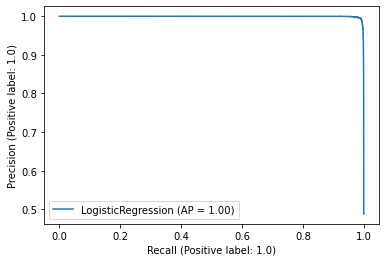

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Reserve 20% of the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(log_reg, X_test, y_test)

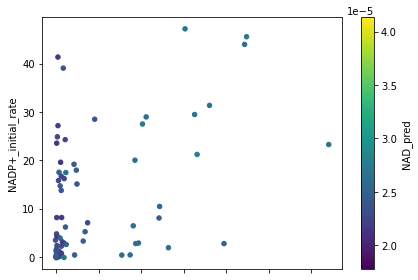

In [61]:
# now train on all training data
# log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(X, y)

nad_prob = log_reg.predict_proba(gapn_reps)[:,1].ravel()
gapn_data['NAD_pred'] = nad_prob
ax = gapn_data.plot.scatter(x="NAD+_initial_rate", y="NADP+_initial_rate", c="NAD_pred", cmap="viridis")
# ax.set_xlabel("NAD+ initial_rate")
plt.xlabel("NAD+ initial_rate")
plt.tight_layout()